In [20]:
import torch
import numpy as np
import torch.nn as nn

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [108]:
def tv_loss(inputs):
    # inputs: [N, C, H, W]
    n, c, h, w = inputs.shape
    grad_x = inputs[:,:,1:,:] - inputs[:,:,:-1,:]
    grad_y = inputs[:,:,:,1:] - inputs[:,:,:,:-1]
    tv = (grad_x.abs().sum() + grad_y.abs().sum()) / (n*c*h*w)
    return tv

In [109]:
batch = torch.rand(10, 3, 256, 256)

In [110]:
comp_field = torch.complex(batch[1, 0,...], batch[1, 1,...])

In [111]:
comp_field.shape

torch.Size([256, 256])

In [191]:
S = 512
z_list = [300, 375]  # SPECIFY TRAINING SAMPLE-TO-SENSOR DISTANCES, [um]
modes = 256
width = 48

batch_size = 2

In [192]:
def batch_fsp(batch, z_list):
    # batch: [N, 2, H, W]
    prop_batch = []
    for n in range(batch.shape[0]):
        comp_field = torch.complex(batch[n,0,...], batch[n,1,...])
        wave = AxialPlane_torch(comp_field, 0, params)
        prop_field = torch.stack([wave(z) for z in z_list], dim=0)  # [C=2, H, W]
        prop_batch.append(prop_field)
    return torch.stack(prop_batch, axis=0)  # [N, C=2, H, W]


class AxialPlane_torch():
    def __init__(self, init_guess, z0, params) -> None:

        # initialize complex field
        self.comp_field = init_guess

        # parameters
        self.z0 = z0
        self.wl = params['wavelength'] / params['ref_ind']  # effective wavelength, [um]
        self.k = 1 / self.wl
        self.n_pixel = params['patch_size']
        self.pixel_size = params['pixel_size']  # [um]
        self.max_freq = 1/self.pixel_size  # [um-1]

    def __call__(self, z):

        # free space propagation using angular spectrum
        ang_spectrum = torch.fft.fftshift(torch.fft.fft2(self.comp_field))

        # create grid                                                    
        uu, vv = np.meshgrid(self.max_freq*np.arange(-np.ceil((self.n_pixel-1)/2), np.floor((self.n_pixel+1)/2))/self.n_pixel,
                    self.max_freq*np.arange(-np.ceil((self.n_pixel-1)/2), np.floor((self.n_pixel+1)/2))/self.n_pixel)
        mask = ((self.k**2 - uu**2 - vv**2) >= 0).astype('float32')
        ww = np.sqrt((self.k**2-uu**2-vv**2)*mask).astype('float32')
        # transfer function
        dz = z - self.z0
        h = np.exp(1j * 2 * np.pi * ww * dz) * mask
        ang_spectrum *= torch.from_numpy(h).to(device)

        # IFFT
        prop_field = torch.fft.ifft2(torch.fft.ifftshift(ang_spectrum))

        return prop_field

In [193]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(1, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(1, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # out_ft = self.ca(out_ft.abs()) * out_ft
        # out_ft = self.sa(out_ft.abs()) * out_ft

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes, width, in_dim, out_dim=2):
        super(FNO2d, self).__init__()
        
        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.conv_begin_0 = nn.Conv2d(in_dim+2, self.width, 1)  # GoPro dataset: RGB 3 channels
        self.conv_begin_1 = nn.Conv2d(self.width, self.width, 1)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv_end1 = nn.Conv2d(self.width, self.width, 1)
        self.conv_end2 = nn.Conv2d(self.width, 2, 1)
        self.prelu_begin = nn.PReLU(self.width)
        self.prelu_end = nn.PReLU(self.width)
        self.lsc = nn.Conv2d(self.width, self.width, 1)

        self.scales_per_block = [1,1,2,2,2,4,4,4]
        self.share_block = [True,True,True,True,True,False,False,False]
        self.num_per_block = [2,2,2,2,2,2,2,2]
        assert len(self.scales_per_block) == len(self.share_block) and len(self.scales_per_block) == len(self.num_per_block)

        self.SConv2d_list = []
        self.w_list = []
        self.prelu_list = []
        self.ssc_list = []
        for i in range(len(self.scales_per_block)):
            print("building scales", i)
            if self.share_block[i]:
                print("\tshared params", end=' ')
                print(self.scales_per_block[i])
                self.SConv2d_list.append(SpectralConv2d_fast(self.width, self.width, self.modes//self.scales_per_block[i], self.modes//self.scales_per_block[i]))
                self.w_list.append(nn.Conv2d(self.width, self.width, 1))
                self.prelu_list.append(nn.PReLU(self.width))
            else:
                print("\tnot shared params", end=' ')
                for _ in range(self.num_per_block[i]):
                    print(self.scales_per_block[i], end=' ')
                    self.SConv2d_list.append(SpectralConv2d_fast(self.width, self.width, self.modes//self.scales_per_block[i], self.modes//self.scales_per_block[i]))
                    self.w_list.append(nn.Conv2d(self.width, self.width, 1))
                    self.prelu_list.append(nn.PReLU(self.width))
                print()
            self.ssc_list.append(nn.Conv2d(self.width, self.width, 1))
        self.SConv2d_list = nn.ModuleList(self.SConv2d_list)
        self.w_list = nn.ModuleList(self.w_list)
        self.prelu_list = nn.ModuleList(self.prelu_list)
        self.ssc_list = nn.ModuleList(self.ssc_list)
        

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        # x = x.permute(0, 3, 1, 2)
        x = self.conv_begin_0(x)
        x = self.prelu_begin(x)
        x = self.conv_begin_1(x)
        x_0 = x
        x_s = x_0
        x_t = x_0
        

        pointer = 0
        for i in range(len(self.scales_per_block)):
            # print(i)
            if self.share_block[i]:
                for _ in range(self.num_per_block[i]):
                    # print("\t",pointer)
                    x = self.SConv2d_list[pointer](x) + self.w_list[pointer](x)
                    x = self.prelu_list[pointer](x)
                    x = x + x_t
                    x_t = x
                pointer += 1
            else:
                for _ in range(self.num_per_block[i]):
                    # print("\t",pointer)
                    x = self.SConv2d_list[pointer](x) + self.w_list[pointer](x)
                    x = self.prelu_list[pointer](x)
                    x = x + x_t
                    x_t = x
                    pointer += 1
            x = self.ssc_list[i](x)
            x = x + x_s
            x_s = x
            x_t = x_s


        x = self.lsc(x)
        x = x + x_0

        x = self.conv_end1(x)
        x = self.prelu_end(x)
        x = self.conv_end2(x)
        # x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        # return [N, C, H, W] grids
        n, c, size_x, size_y = shape
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([n, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([n, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)

In [200]:
model = FNO2d(modes, width, len(z_list), 2).cuda()

building scales 0
	shared params 1
building scales 1
	shared params 1
building scales 2
	shared params 2
building scales 3
	shared params 2
building scales 4
	shared params 2
building scales 5
	not shared params 4 4 
building scales 6
	not shared params 4 4 
building scales 7
	not shared params 4 4 


In [201]:
model

FNO2d(
  (conv_begin_0): Conv2d(4, 48, kernel_size=(1, 1), stride=(1, 1))
  (conv_begin_1): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (conv_end1): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (conv_end2): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
  (prelu_begin): PReLU(num_parameters=48)
  (prelu_end): PReLU(num_parameters=48)
  (lsc): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  (SConv2d_list): ModuleList(
    (0): SpectralConv2d_fast()
    (1): SpectralConv2d_fast()
    (2): SpectralConv2d_fast()
    (3): SpectralConv2d_fast()
    (4): SpectralConv2d_fast()
    (5): SpectralConv2d_fast()
    (6): SpectralConv2d_fast()
    (7): SpectralConv2d_fast()
    (8): SpectralConv2d_fast()
    (9): SpectralConv2d_fast()
    (10): SpectralConv2d_fast()
  )
  (w_list): ModuleList(
    (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
    (3): Co

In [202]:
# myloss = LpLoss(size_average=False)
maeloss = nn.L1Loss(reduction='mean')
mseloss = nn.MSELoss()
# wavelength: [um], pixel_size: [um], patch_size: [px], ref_ind: refractive index of the medium, air is 1.0
params = {'wavelength':0.530,'pixel_size':0.3733,'patch_size':S,'ref_ind':1.00}  # SPECIFY YOUR TRAINING SETUPS
# Fourier domain window
hann_window = torch.outer(torch.hann_window(S), torch.hann_window(S))  # 2D Hann window
hann_window = torch.fft.ifftshift(hann_window).unsqueeze(0).unsqueeze(0).cuda()

In [203]:
hann_window.shape

torch.Size([1, 1, 512, 512])

In [204]:
inputs = torch.rand(1, 3, 512, 512).cuda()

In [205]:
tvl = tv_loss(inputs)

In [206]:
tvl

tensor([0.6651])

In [207]:
xx = torch.rand(1, 2, 512, 512).cuda()
im = model(xx)

In [208]:
im.shape

torch.Size([1, 2, 512, 512])

In [209]:
im_x = torch.abs(batch_fsp(im, z_list))

In [210]:
im_x.shape

torch.Size([1, 2, 512, 512])

In [211]:
# normalize a complex field by dividing its complex mean
def comp_field_norm(comp_field):
    # comp_field [N, C=2 (real&imag), H, W] or [C, H, W]
    if isinstance(comp_field, np.ndarray):
        if comp_field.ndim == 3:
            comp_field = comp_field[0,...] + 1j*comp_field[1,...]
            comp_field /= (np.mean(np.abs(comp_field), axis=(-2,-1), keepdims=True) * np.exp(1j*np.mean(np.angle(comp_field), axis=(-2,-1), keepdims=True)))
            comp_field /= np.mean(comp_field, axis=(-2,-1), keepdims=True)
            return np.stack((np.real(comp_field), np.imag(comp_field)), axis=0)
        elif comp_field.ndim == 4:
            comp_field = comp_field[:,0,...] + 1j*comp_field[:,1,...]
            comp_field /= (np.mean(np.abs(comp_field), axis=(-2,-1), keepdims=True) * np.exp(1j*np.mean(np.angle(comp_field), axis=(-2,-1), keepdims=True)))
            comp_field /= np.mean(comp_field, axis=(-2,-1), keepdims=True)
            return np.stack((np.real(comp_field), np.imag(comp_field)), axis=1)
    elif isinstance(comp_field, torch.Tensor):
        comp_field = comp_field[:,0,...] + 1j*comp_field[:,1,...]
        comp_field /= (torch.mean(torch.abs(comp_field), dim=(-2,-1), keepdim=True) * torch.exp(1j*torch.mean(torch.angle(comp_field), dim=(-2,-1), keepdim=True)))
        comp_field /= torch.mean(comp_field, dim=(-2,-1), keepdim=True)
        return torch.stack([torch.real(comp_field), torch.imag(comp_field)], dim=1)

In [212]:
loss = 0
train_mse = 0
loss += maeloss(torch.fft.fft2(im_x) * hann_window, torch.fft.fft2(xx) * hann_window) * 0.1  # LOSS WEIGHTS MAY VARY FROM CASE TO CASE
loss += mseloss(im_x, xx)*1.0 + tv_loss(im)*20.0

# train_mse += mseloss(comp_field_norm(im.detach().cpu()), comp_field_norm(xx.detach().cpu())).detach().item()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [213]:
loss

tensor(3.3510, device='cuda:0', grad_fn=<AddBackward0>)

In [214]:
(torch.fft.fft2(im_x) * hann_window).shape

torch.Size([1, 2, 512, 512])

In [215]:
(torch.fft.fft2(xx) * hann_window).shape

torch.Size([1, 2, 512, 512])

In [174]:
x = torch.rand(10, 3, 512, 512)

In [175]:
mseloss(x, x)

tensor(0.)

In [171]:
tv_loss(x)

ValueError: not enough values to unpack (expected 4, got 3)

In [178]:
import torch

def tv_loss(inputs):
    # inputs: [N, C, H, W]
    n, c, h, w = inputs.shape
    grad_x = inputs[:, :, :, 1:] - inputs[:, :, :, :-1]
    grad_y = inputs[:, :, 1:, :] - inputs[:, :, :-1, :]
    tv = torch.sum(torch.abs(grad_x)) + torch.sum(torch.abs(grad_y))
    print(tv)
    return tv / (n * c * h * w)

# Example usage
if __name__ == "__main__":
    # Generate some random data (replace this with your own data)
    N = 10  # Number of images in the batch
    C = 3   # Number of channels
    H = 256 # Height
    W = 256 # Width

    inputs = torch.randn(N, C, H, W)

    # Calculate TV loss
    tv_loss_value = tv_loss(inputs)

    print("Total Variation Loss:", tv_loss_value.item())


tensor(4420240.5000)
Total Variation Loss: 2.2482504844665527


In [184]:
import torch

def tv_loss(inputs):
    # inputs: [N, C, H, W]
    n, c, h, w = inputs.shape
    tv_losses = torch.zeros(n)  # Initialize a tensor to store individual losses
    
    for i in range(n):
        grad_x = inputs[i, :, :, 1:] - inputs[i, :, :, :-1]
        grad_y = inputs[i, :, 1:, :] - inputs[i, :, :-1, :]
        tv_losses[i] = torch.sum(torch.abs(grad_x)) + torch.sum(torch.abs(grad_y))
    
#     batch_tv_loss = torch.mean(tv_losses)  # Calculate the average TV loss for the batch
    return tv_losses/ (c * h * w)

# Example usage
if __name__ == "__main__":
    N = 10  # Number of images in the batch
    C = 3   # Number of channels
    H = 256 # Height
    W = 256 # Width

    inputs = torch.randn(N, C, H, W)

    # Calculate TV loss for the batch
    batch_tv_loss = tv_loss(inputs)

    print("Batch Total Variation Loss:", batch_tv_loss)


Batch Total Variation Loss: tensor([2.2500, 2.2514, 2.2482, 2.2516, 2.2480, 2.2408, 2.2477, 2.2461, 2.2428,
        2.2504])


In [83]:
hann_window.min()

tensor(0.)

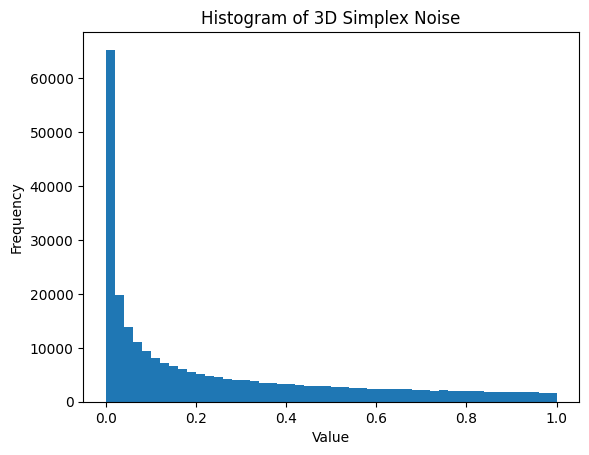

In [84]:
import matplotlib.pyplot as plt
# Generate random noise
noise = hann_window.flatten().cpu().numpy()
# Plot the histogram
plt.hist(noise, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 3D Simplex Noise')
plt.show()

In [85]:
hann_window = torch.fft.ifftshift(hann_window).unsqueeze(0).unsqueeze(0).cuda()

In [86]:
hann_window

tensor([[[[1.0000, 1.0000, 0.9998,  ..., 0.9997, 0.9998, 1.0000],
          [1.0000, 0.9999, 0.9998,  ..., 0.9996, 0.9998, 0.9999],
          [0.9998, 0.9998, 0.9997,  ..., 0.9995, 0.9997, 0.9998],
          ...,
          [0.9997, 0.9996, 0.9995,  ..., 0.9993, 0.9995, 0.9996],
          [0.9998, 0.9998, 0.9997,  ..., 0.9995, 0.9997, 0.9998],
          [1.0000, 0.9999, 0.9998,  ..., 0.9996, 0.9998, 0.9999]]]],
       device='cuda:0')

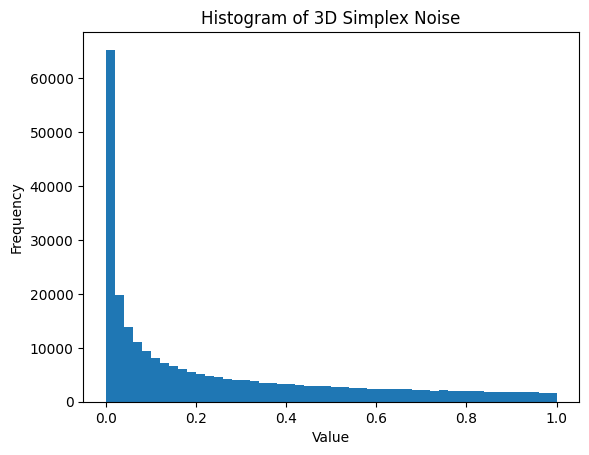

In [87]:
import matplotlib.pyplot as plt
# Generate random noise
noise = hann_window.flatten().cpu().numpy()
# Plot the histogram
plt.hist(noise, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 3D Simplex Noise')
plt.show()